In [56]:
import pandas as pd
import numpy as np 
import os 
import glob
import re
from pigeon import annotate
from IPython.display import display, Image
import cv2
import mtcnn
import pickle 

from FaceNet.architecture import * 
from modules.heic_to_jpg import convert_heic_to_jpg_from_directory
from modules.face_detection import face_detection_from_source_folder
from modules.data_processing import train_test_split_labeled_data
from modules.data_processing import copy_images_to_new_folder
import modules.face_recog_v2

from sklearn.preprocessing import Normalizer
from tensorflow.keras.models import load_model

In [58]:
######pathsandvairables#########
face_data = 'data/train/'
required_shape = (160,160)
face_encoder = InceptionResNetV2()
path = "facenet_keras_weights.h5"
face_encoder.load_weights(path)
face_detector = mtcnn.MTCNN()
encodes = []
encoding_dict = dict()
l2_normalizer = Normalizer('l2')
###############################

# Step 0: Download photos

Download a bunch of photos as training data (I'm using google photos, but you can use whatever you want). The first step is to convert those photos to a usable file format (`.jpg`, `.jpeg`, `.png`). 

# Step 1: Convert photos from HEIC to jpg

Apple's default image format is HEIC, so I had a ton of these files in my training dataset. Let's convert those files to `.jpg`. 

Note: We'll need to add other converters to modules as appropriate. I haven't run into any other issues yet, but I anticipate running into some roadblocks when we expand the size of our training set. 

In [ ]:
# Convert files from HEIC to .jpg - for the sake of demonstration, we'll just use a test image
convert_heic_to_jpg_from_directory('data/heic-test', 'data/heic-test', 'test') 


# Step 2: Perform Face Detection on all images in the source directory

Use the MTCNN library to perform face detection on all images in the input directory. Save these images for facial recognition. 

Note: This runs faster in [Colab](https://colab.research.google.com/drive/14u8vAMn7Q86CXDorwqJedZOWs7AkNdGr#scrollTo=mWD21uA90BGD). 


In [ ]:
# perform face detection
face_detection_from_source_folder('data/fullimages', 'data/allfaces', 'image', size = 100)

# Note: Uncomment the lines below to perform face detection for specific people 
# face_detection_from_source_folder('data/images-custom/seth', 'data/images-custom/sethfaces', 'seth', size = 100)
# face_detection_from_source_folder('data/images-custom/claire', 'data/images-custom/clairefaces', 'claire', size = 100)
# face_detection_from_source_folder('data/images-custom/jordyn', 'data/images-custom/jordynfaces', 'jordyn', size = 100)


# Step 3: Label the Faces for Training purposes

In iteration 1, we're going to manually label the faces for training. This isn't scalable, so we've explored unsupervised ways of identifying faces. However, we haven't had a ton of success with this so far, so we've decided to implement manual labeling and move on with the MVP. 
 
We did a lot of face clustering and anomaly detection work, but it wasn't very successful. It's pretty computationally expensive, so we did it in [Colab](https://colab.research.google.com/drive/14u8vAMn7Q86CXDorwqJedZOWs7AkNdGr#scrollTo=mWD21uA90BGD). 

In [ ]:
import pandas as pd
import glob

from pigeon import annotate
from IPython.display import display, Image

SourceFolder = 'data/allfaces/'
TargetFilename = 'data/faces_labeled_full.csv'
label_options = ['seth', 'claire', 'jordyn', 'none']

# Get a list of all jpg image filenames in the source directory 
jpgFilenamesList = glob.glob(SourceFolder + '*.jpg')
annotations = annotate(
  jpgFilenamesList,
  options=label_options,
  display_fn=lambda filename: display(Image(filename))
)

df_faces = pd.DataFrame(annotations, columns = ['filename', 'label'])

print("Distribution of Labels:")
print(df_faces.label.value_counts() / df_faces.shape[0])

df_faces.to_csv(TargetFilename)


# Step 4: Perform a Training and Testing Split for your labeled faces 

The face detection library (and training for other models like tensorflow's VGG16 and Hugging Face's ViT which I'd like to experiment with) assumes that the data are in a certain directory structure for training. They want a `train` and `test` directory where each unique face has its own subdirectory. To accomodate this, run the following cells. 

Note: If you performed face detection and/or labeling with Colab, you'll need to run the cell below to convert the filenames in the labeled data set.

In [ ]:
# (optional) Convert from Colab format to containerized application 
import re

df_labeled = pd.read_csv('data/faces_labeled_from_colab.csv', index_col=[0])
# df_labeled.filename = 
s = df_labeled.filename.str.replace(r'^drive/MyDrive/', '')
s = s.str.replace('faces_final','faces-final')
df_labeled.filename = s
df_labeled.to_csv('data/faces_labeled.csv')


In [ ]:
test_size = 0.3
path_to_labeled_data = 'data/faces_labeled.csv'

train, test = train_test_split_labeled_data(path_to_labeled_data, test_size)

copy_images_to_new_folder(train, 'data/train')
copy_images_to_new_folder(test, 'data/test')

# Step 5: Train a Facial Recognition classifier

Take the faces and use the facial recognition library to get latent space encodings. Then, train a KNN classifier on the latent space encodings for images in the training set and evaluate it on the test set. 

Note: For illustration, I'm only using my own test faces. 


In [47]:
from modules import face_recog_v2
import os

# Uncomment to train the classifier 
print("Training KNN classifier...")
classifier = face_recog_v2.train("data/train", model_save_path="models/trained_knn_model_v2.clf", n_neighbors=2)
print("Training complete!")


Training KNN classifier...
.DS_Store
claire
seth
jordyn
Training complete!


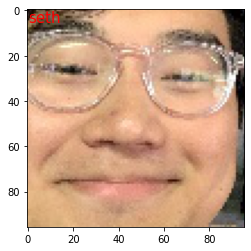

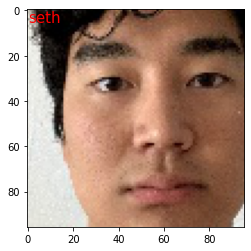

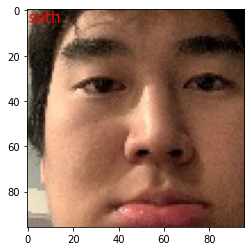

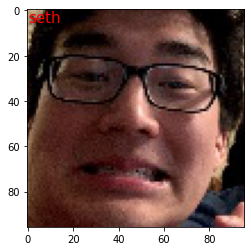

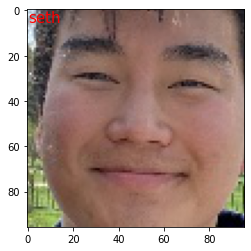

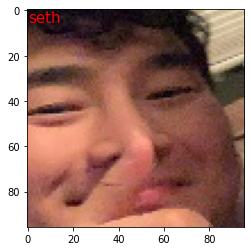

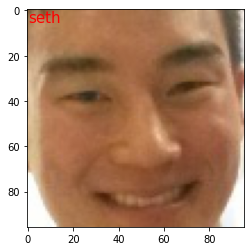

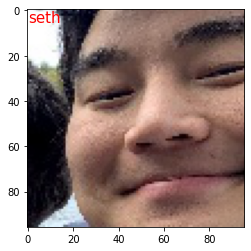

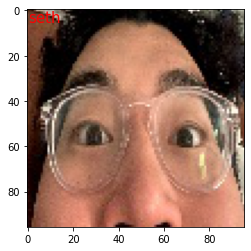

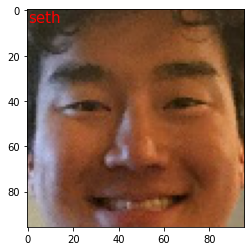

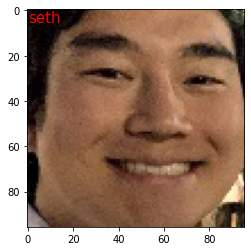

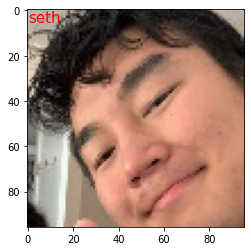

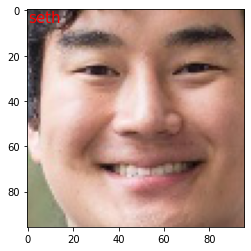

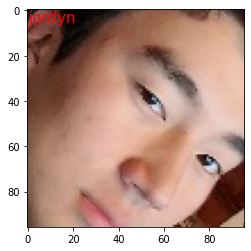

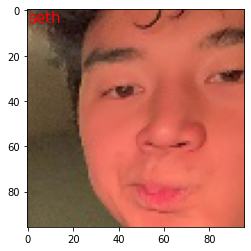

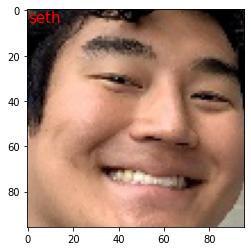

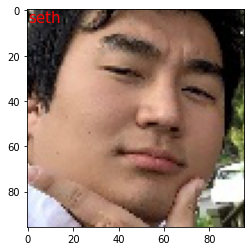

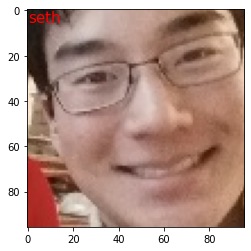

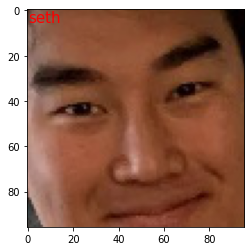

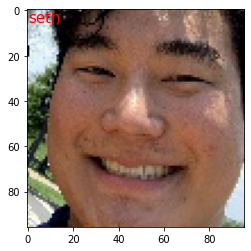

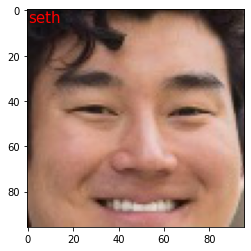

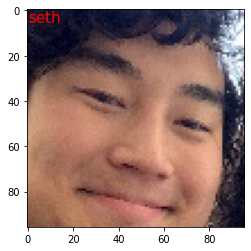

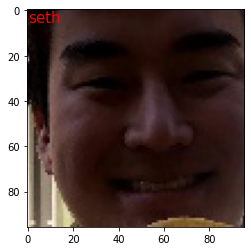

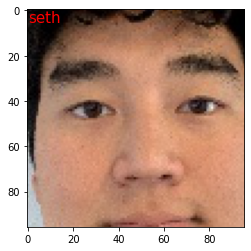

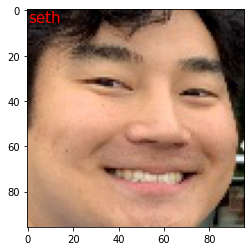

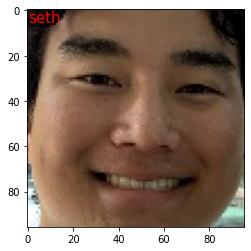

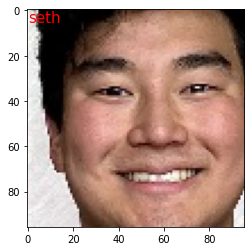

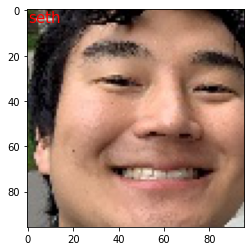

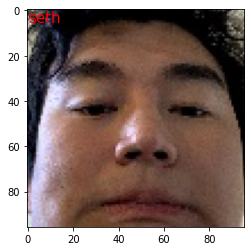

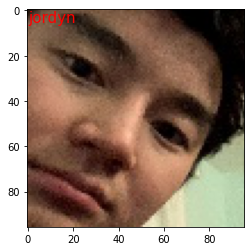

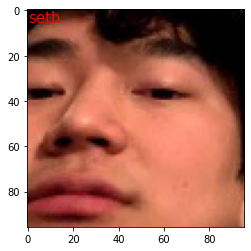

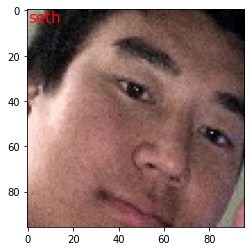

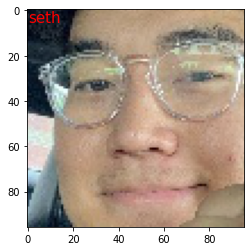

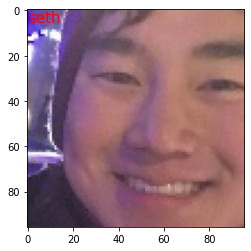

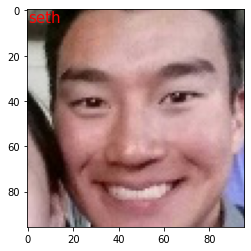

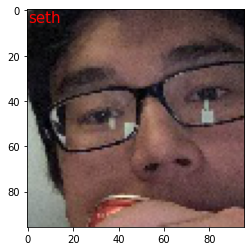

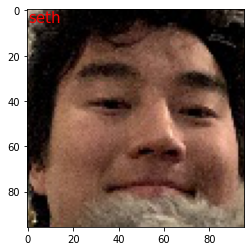

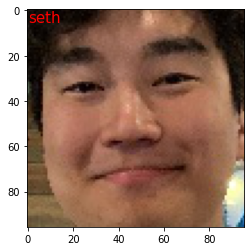

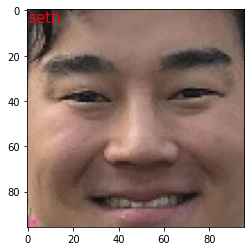

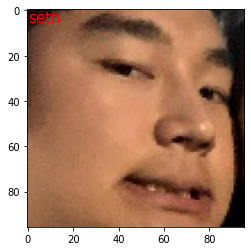

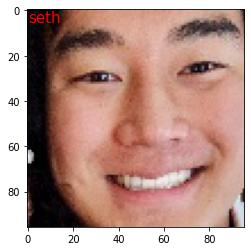

In [49]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np 

names = []
# Iterate over test images
for image_file in os.listdir("data/test/seth"):
    if image_file[len(image_file)-1] != 'g':
        continue
    
    full_file_path = os.path.join("data/test/seth", image_file)

    # Get encodings and predict
    encoding = get_encodings_from_face_path(full_file_path)
    label = knn_clf.predict(encoding.reshape(1,-1))[0]
    names.append(label)
    
    pil_image = Image.open(full_file_path).convert("RGB")
    figure, ax = plt.subplots(1)
    ax.imshow(np.array(pil_image))

    ax.text(0, 5, label,color='red', fontsize=15)
    plt.show()


In [50]:
print(f"Prediction accurary on the Test set: {round(np.mean(np.array(names) == 'seth'), 3)}")

Prediction accurary on the Test set: 0.951


In [53]:
def get_predictions(path):
    names = []
    # STEP 2: Using the trained classifier, make predictions for unknown images
    for image_file in os.listdir(path):
        if image_file[len(image_file)-1] != 'g':
            continue
        full_file_path = os.path.join(path, image_file)

        # Find all people in the image using a trained classifier model
        # Note: You can pass in either a classifier file name or a classifier model instance
        # Get encodings and predict
        encoding = get_encodings_from_face_path(full_file_path)
        label = knn_clf.predict(encoding.reshape(1,-1))[0]
        names.append(label)

    return np.array(names)

In [54]:
print(f"Prediction accurary on the Test set - Claire: {round(np.mean(get_predictions('data/test/claire') == 'claire'), 3)}")
print(f"Prediction accurary on the Test set - Jordyn: {round(np.mean(get_predictions('data/test/jordyn') == 'jordyn'), 3)}")


Prediction accurary on the Test set - Claire: 0.964
Prediction accurary on the Test set - Jordyn: 0.96


## End of training pipeline

- TODO, make this into an executable script and instrument it. 